# Kidney Exchange QAOA Example

Author: Bill Wisotsky  

---

<u>What is the Problem?</u>  
Currently there are more than 100,000 patients on the waitling list in the United States for a kidney transplant from a deceased donor. This is addressed by the a program called the Kidney Exchange Program.  This program won the Nobel Prize in Economics for Alvin E. Roth and Lloyd S. Shapley's contributions to the <i>theory of stable matchings and the design of markets on 2012.</i>
In summary, in a donor pair there is a recipient who needs a kidney transplant and a donor who is willing to give their kidney to the recipient. About $\frac{1}{3}$ of those pairs are not compatible for a direct exchange. This is tackled by considering two incompatible pairs together: donor 1 may be compatible with recpient 2 and donor 2 may be compatible with recpient 1. In this example a two-way swap becomes feasible. This is the core of the kideny exchange program.  

This is consdered an NP-Hard combinatorial optimization problem that becomes exponetially more difficult as the size of the pool increases. The longest chain in history involved 35 tranplants in the United States in 2015.

In [1]:
import warnings
from itertools import product
from typing import List, Tuple, cast  # noqa

import networkx as nx  # noqa
import numpy as np

from classiq import *

warnings.filterwarnings("ignore")

## Create the pyomo model for a simple kidney exhange problem 

In this very simple example, patients and donors represent sets of patients that receive a kidney from a donor. Compatibility is a dictionary mapping of patient-donor paris to their compatibilty scores. Binary decision variables are defined for each patient-donor pair x[donor,patient]. The objective is to maximize the total compatibility score. $ Maximize \sum_{d,p\in A}^{} \sum_{m\in M}c_{dp}x_{dpm}$ where d=donors, p=patients and c=compatability score. The contraints are added to ensure that each donor donates only once $\sum_{d,p\in A}^{}x_{dpm} = y_{dm}$ and each patient receives once $\sum_{d,p\in A}^{}x_{dpm} = y_{pm}$. We are creating a PYOMO model that gets fed into Classiq, as illustrated in Classiq documentation. We also solve initially with a classical solver to get inital results which can be compared to the QAOA results in the end.

In [2]:
from pyomo.environ import *

# Sample data: patient-donor pairs and compatibility scores
donors = ["donor1", "donor2", "donor3"]
patients = ["patient1", "patient2", "patient3"]
N = len(patients)
M = len(donors)
# Parameters
compatibility_scores = {
    ("donor1", "patient1"): 0.9,
    ("donor1", "patient2"): 0.7,
    ("donor1", "patient3"): 0.6,
    ("donor2", "patient1"): 0.8,
    ("donor2", "patient2"): 0.75,
    ("donor2", "patient3"): 0.65,
    ("donor3", "patient1"): 0.85,
    ("donor3", "patient2"): 0.8,
    ("donor3", "patient3"): 0.7,
}

# Create Pyomo model
model = ConcreteModel()

# Variables
model.x = Var(donors, patients, within=Binary)

# Objective
model.obj = Objective(
    expr=sum(
        compatibility_scores[donor, patient] * model.x[donor, patient]
        for donor in donors
        for patient in patients
    ),
    sense=maximize,
)

# Constraints
model.donor_constraint = ConstraintList()
for donor in donors:
    model.donor_constraint.add(
        sum(model.x[donor, patient] for patient in patients) <= 1
    )

model.patient_constraint = ConstraintList()
for patient in patients:
    model.patient_constraint.add(sum(model.x[donor, patient] for donor in donors) <= 1)

# Install "glpk" and unommente for runing this part
# Solve
# solver = SolverFactory("glpk")
# solver.solve(model)

# Output
print("\033[1m\033[4mOptimal solution:\033[0m")
for donor in donors:
    for patient in patients:
        if model.x[donor, patient].value == 1:
            print(f"{donor} donates kidney to {patient}")

print("\n\033[1m\033[4mModel Details\033[0m")
model.pprint()

Optimal solution:

Model Details
5 Set Declarations
    donor_constraint_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    patient_constraint_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : x_index_0*x_index_1 :    9 : {('donor1', 'patient1'), ('donor1', 'patient2'), ('donor1', 'patient3'), ('donor2', 'patient1'), ('donor2', 'patient2'), ('donor2', 'patient3'), ('donor3', 'patient1'), ('donor3', 'patient2'), ('donor3', 'patient3')}
    x_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'donor1', 'donor2', 'donor3'}
    x_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dime

## Start Generatng the QAOA Process
  
### Create the inital parameters for the quantum circuit. These can me modified as needed.
1. Defining the number of layers (num_layers) of the QAOA Ansatz.  
2. Define the penalty_energy for invalid solutions, which influences the convergence rate. Smaller positive values are preferred, but shoudl be tweaked.  


In [7]:
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=model, num_layers=5, penalty_factor=2)

# defining cosntraint such as computer and parameters for a quicker and more optimized circuit.
preferences = Preferences(transpilation_option="none", timeout_seconds=300)
constraints = Constraints(optimization_parameter="width")

qmod = combi.get_model(preferences=preferences, constraints=constraints)

In [8]:
write_qmod(qmod, "kidney_exchange_problem")  # optional

### Combine everthing together to form the entire QAOA model as a QMOD.

1. Sythesize the quantum model
2. Show the quantm model in the Classiq platform

In [9]:
qprog = combi.get_qprog()
show(qprog)

Quantum program link: https://nightly.platform.classiq.io/circuit/2zopraGwGOlRdR30f0cw8y0aehj


### Define classical optimizer part of the QAOA. 

These parameters can be modified:
1. The `max_iterations` is the maximum number of optimzer iterations and is set to 100.  
2. The `quantile` is a parameter that describes the quantile considered in the CVAR expectation value. See https://arxiv.org/abs/1907.04769 for more information.
   
Execute the quantum model and store the result.

In [10]:
optimized_params = combi.optimize(maxiter=100, quantile=0.7)

View the convergence graph  
<i>Important to remember that this is a maximization problem when looking at the graph</i>

Text(0.5, 1.0, 'Cost convergence')

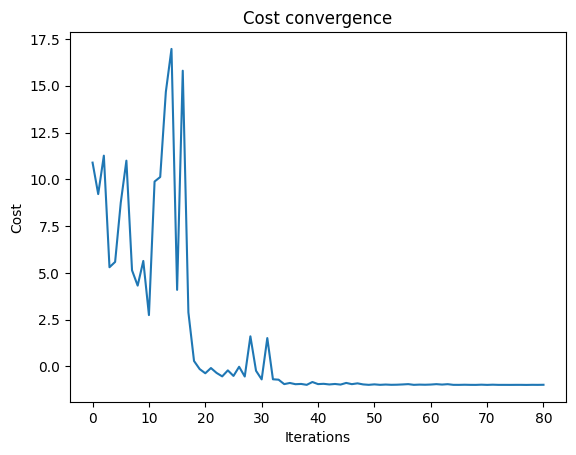

In [11]:
import matplotlib.pyplot as plt

plt.plot(combi.cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

## Retrieve and Display the Solutions
- Print them out
- Graph using a histogram
- Show Donor - Recipients in Network Graph

### Print out the top 10 solutions with the highest cost or objective

In [28]:
optimization_result = combi.sample(optimized_params)

print("\n\033[1m\033[4mTop 10 Solutions\033[0m")
optimization_result.sort_values(by="cost", ascending=True).head(10)


Top 10 Solutions


,solution,probability,cost
17,"{'x_donor1_patient1': 1, 'x_donor1_patient2': ...",0.012207,-2.35
22,"{'x_donor1_patient1': 1, 'x_donor1_patient2': ...",0.011230,-2.35
29,"{'x_donor1_patient1': 0, 'x_donor1_patient2': ...",0.009766,-2.20
26,"{'x_donor1_patient1': 0, 'x_donor1_patient2': ...",0.010742,-2.20
18,"{'x_donor1_patient1': 0, 'x_donor1_patient2': ...",0.011719,-2.20
31,"{'x_donor1_patient1': 0, 'x_donor1_patient2': ...",0.008789,-2.20
14,"{'x_donor1_patient1': 1, 'x_donor1_patient2': ...",0.013184,-1.70
25,"{'x_donor1_patient1': 1, 'x_donor1_patient2': ...",0.010742,-1.65
32,"{'x_donor1_patient1': 0, 'x_donor1_patient2': ...",0.008301,-1.60
19,"{'x_donor1_patient1': 0, 'x_donor1_patient2': ...",0.011230,-1.60


### Histogram of Cost and Weighted by Probability

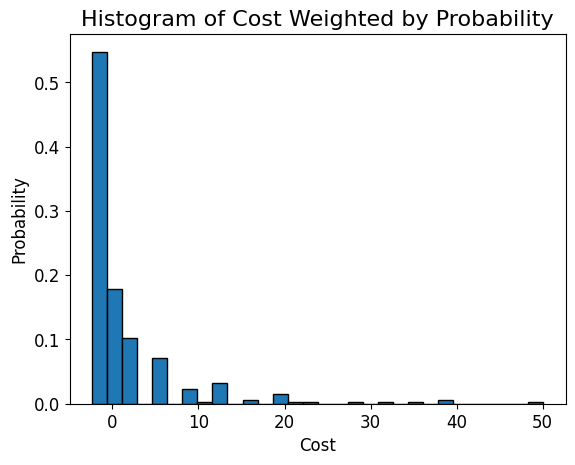

In [13]:
import matplotlib.pyplot as plt

optimization_result["cost"].plot(
    kind="hist", bins=30, edgecolor="black", weights=optimization_result["probability"]
)
plt.ylabel("Probability", fontsize=12)
plt.xlabel("Cost", fontsize=12)
plt.tick_params(axis="both", labelsize=12)
plt.title("Histogram of Cost Weighted by Probability", fontsize=16)
plt.show()

### Create a Network Graph for the Best Solution Found
<b>$\star$ Very important to remember that this is a mximization problem and the classical solver of the QAOA process returns all possible results. We need to filter out the solution with the highest cost which would represent the the highest compatability score. </b>

In [27]:
best_solution.solution

{'x_donor1_patient1': 1,
 'x_donor1_patient2': 1,
 'x_donor1_patient3': 1,
 'x_donor2_patient1': 0,
 'x_donor2_patient2': 1,
 'x_donor2_patient3': 1,
 'x_donor3_patient1': 1,
 'x_donor3_patient2': 1,
 'x_donor3_patient3': 1}

** QAOA SOLUTION **
Highest Compatibility Score =  2.35
        patient1  patient2  patient3
donor1         1         0         0
donor2         0         0         1
donor3         0         1         0


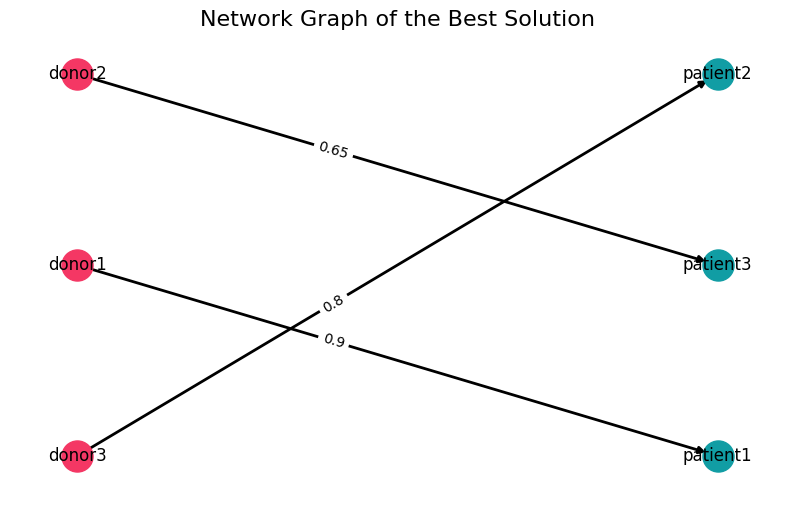

In [34]:
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd


def plotting_sol(x_sol, cost):
    # Extract donor and patient names from keys
    donors = sorted(set(key.split("_")[1] for key in x_sol.keys()))
    patients = sorted(set(key.split("_")[2] for key in x_sol.keys()))
    N = len(donors)
    M = len(patients)

    # Create mapping to matrix
    x_mat = np.zeros((N, M), dtype=int)
    for key, val in x_sol.items():
        donor = key.split("_")[1]
        patient = key.split("_")[2]
        i = donors.index(donor)
        j = patients.index(patient)
        x_mat[i, j] = val

    print("\033[1m\033[4m** QAOA SOLUTION **\033[0m")
    print("\033[4mHighest Compatibility Score\033[0m = ", cost)

    # Table view
    df = pd.DataFrame(x_mat, index=donors, columns=patients)
    print(df)

    # Graph view
    graph_sol = nx.DiGraph()
    graph_sol.add_nodes_from(donors + patients)

    for i, j in product(range(N), range(M)):
        if x_mat[i, j] > 0:
            graph_sol.add_edge(
                donors[i],
                patients[j],
                weight=compatibility_scores[(donors[i], patients[j])],
            )  # Default weight

    plt.figure(figsize=(10, 6))
    pos = nx.bipartite_layout(graph_sol, donors)

    nx.draw_networkx_nodes(
        graph_sol, pos, nodelist=donors, node_color="#F43764", node_size=500
    )
    nx.draw_networkx_nodes(
        graph_sol, pos, nodelist=patients, node_color="#119DA4", node_size=500
    )
    nx.draw_networkx_labels(graph_sol, pos, font_size=12)

    nx.draw_networkx_edges(graph_sol, pos, width=2)
    labels = nx.get_edge_attributes(graph_sol, "weight")
    nx.draw_networkx_edge_labels(
        graph_sol, pos, edge_labels=labels, font_size=10, label_pos=0.6
    )

    plt.title("Network Graph of the Best Solution", fontsize=16)
    plt.axis("off")
    plt.show()


best_solution = optimization_result.loc[optimization_result.cost.idxmin()]
plotting_sol(best_solution.solution, -best_solution.cost)